<h1>ISIC Part 2 - Detect Dermoscopic Criteria - Infer</h1>
<p>Given a trained model, detect the presence of dermoscopic criteria within a dermoscopic image.</p>

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import os
import sys
import json
import numpy as np
import matplotlib.pyplot as plt
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))

In [2]:
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input

Using TensorFlow backend.


In [3]:
from skinisic.kerasutils import load_preprocess_image
from skinisic.kerasmodels import fcn_vgg_bottomheavy
from skinisic.isicutils import rgb2index
from skinisic.vis import plot_img_preds
from skinisic.utils import imresize3d

<h2>Download the trained model</h2>
<p>This downloads the trained weights for the CNN. This model is the top model with respect to J_NAN as described in the paper. Specifically, this is the Dice-F1-Channel-Batch model trained with image and sample augmentation.</p>
<pre>
J. Kawahara and G. Hamarneh, “Fully convolutional neural networks to detect clinical dermoscopic features,” IEEE J. Biomed. Heal. Informatics, vol. 23, no. 2, pp. 578–585, 2019. https://doi.org/10.1109/JBHI.2018.2831680
</pre>
Preprint: https://arxiv.org/abs/1703.04559

In [4]:
# Uncomment to download the model if you have not already (you only need to do this once)
#!wget -P data "https://github.com/jeremykawahara/skinisic/releases/download/v0.0.1/isic2017-part2_vgg_f1-batch_aug.h5"

In [5]:
# Specifiy where the weights of the trained model are.
model_path = 'data/isic2017_part2_vgg_f1-batch_aug.h5'

<h2>Load the trained CNN</h2>

In [6]:
# This the channel order that the CNN outputs the dermoscopic criteria.
# i.e., channel 0 = pigment network, channel 1 = negative network, etc ...
dermoscopic_labels = ['pigment_network', 'negative_network', 'milia_like_cyst', 'streaks']

# Size of the image the CNN expects.
target_size = (336,336,3)

In [7]:
# Create the model without the trained weights.
model = fcn_vgg_bottomheavy(target_size, nb_labels=len(dermoscopic_labels))

In [8]:
# Load the trained weights of the model.
model.load_weights(model_path)

<h2>Select and read image</h2>

In [9]:
# Directory where the image data and superpixels are stored.
# Included a sample test image from the ISIC challenge here.
dir_images = 'data/ISIC-2017_Test_v2_Data/'

In [10]:
# The specific case i.e., a particular image with corresponding superpixels and superpixel labels.
case_name = 'ISIC_0012758'

In [11]:
# Original image before resizing.
img_path = os.path.join(dir_images, case_name + '.jpg')
img = np.asarray(image.load_img(img_path))
print(img.shape)

(602, 639, 3)


<h2>Compute the CNN's predictions</h2>

In [12]:
# Preprocess the image for the CNN.
pre_img = load_preprocess_image(img_path, preprocess_function=preprocess_input, target_size=target_size)

In [13]:
# Forward pass to get the predictions.
y_pred = model.predict(pre_img)
y_pred = np.squeeze(y_pred)
print(y_pred.shape)

(336, 336, 4)


In [14]:
# Resize the predictions to match the original image.
y_pred = imresize3d(np.squeeze(y_pred), img.shape)
print(y_pred.shape)

(602, 639, 4)


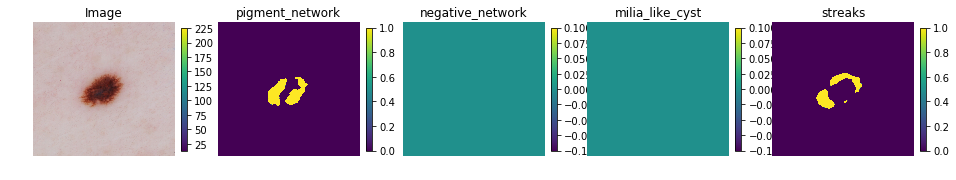

In [15]:
# These are the predictions made by the CNN.
# A `1` indicates the presence of the feature.
# Both negative_network and mila_like_cyst are predicted to be absent from this image.
plot_img_preds(img, y_pred, labels=dermoscopic_labels)

<h2>Ground truth labels</h2>
<p>If you only need the CNN predictions, you can stop here. The following code converts the superpixel labels to image space. This can be slow so we use Cython (C for Python) to speed things up.</p>

In [16]:
# Only need to run this once to build the Cython files.
# This is needed for the `compute_superseg` function.
%run ../skinisic/cython_setup.py build_ext --build-lib="../"

running build_ext


In [17]:
from skinisic.converter import compute_superseg

In [18]:
# Load the superpixels.
superpixels = image.load_img(os.path.join(dir_images, case_name + '_superpixels.png'))
superpixels = np.asarray(superpixels)
superpixels.shape # Superpixels are encoded as RGB.

(602, 639, 3)

In [19]:
# Convert so each superpixel has a unique index.
superindexes = rgb2index(superpixels)
superindexes.shape

(602, 639)

In [20]:
# Where the ground truth JSON files are located.
dir_json = 'data/ISIC-2017_Test_v2_Part2_GroundTruth'

In [21]:
# Load the corresponding json ground truth labels.
with open(os.path.join(dir_json, case_name + '_features.json')) as data_file:
    json_dict = json.load(data_file)

# Convert the dictonary to an array.
json_array = np.asarray([json_dict[label] for label in dermoscopic_labels], dtype=np.float32)
print(json_array.shape) 
# 4 dermoscopic labels with 959 superpixels.

(4, 959)


In [22]:
# Convert the superpixel labels to a superpixel segmentation,
# where each pixel in each of the 4 dermoscopic features are labeled.
superseg = compute_superseg(superindexes, json_array)
print(superseg.shape)

(602, 639, 4)


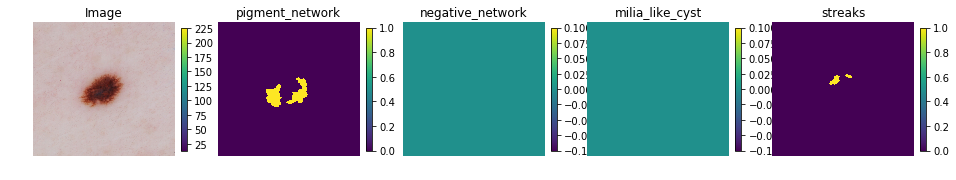

In [23]:
# Ground truth labels.
plot_img_preds(img, superseg, labels=dermoscopic_labels)